In [ ]:
!wget --header="Host: doc-0s-5k-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,mt;q=0.8,hi;q=0.7" --header="Cookie: AUTH_2u1gmt4j08s836ujksdlj51vps0jhs16=12878554966299595518|1633715625000|kcsd6dainfv0ndf044lkdc0mdi7435it" --header="Connection: keep-alive" "https://doc-0s-5k-docs.googleusercontent.com/docs/securesc/6kbudo4ee5hqmlq3ia8ppia9sbcvjuvj/o7sld0eqhc4sthcdv80s11mlgigggcei/1633715625000/12878554966299595518/12878554966299595518/1jqMhtzlops8iBUTwYDiIAA2s1JucXd1t?e=download&authuser=0" -c -O 'df_data.csv'

--2021-10-08 17:54:36--  https://doc-0s-5k-docs.googleusercontent.com/docs/securesc/6kbudo4ee5hqmlq3ia8ppia9sbcvjuvj/o7sld0eqhc4sthcdv80s11mlgigggcei/1633715625000/12878554966299595518/12878554966299595518/1jqMhtzlops8iBUTwYDiIAA2s1JucXd1t?e=download&authuser=0
Resolving doc-0s-5k-docs.googleusercontent.com (doc-0s-5k-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0s-5k-docs.googleusercontent.com (doc-0s-5k-docs.googleusercontent.com)|74.125.204.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33697872 (32M) [text/csv]
Saving to: ‘df_data.csv’

df_data.csv         100%[===================>]  32.14M  83.7MB/s    in 0.4s    

2021-10-08 17:54:37 (83.7 MB/s) - ‘df_data.csv’ saved [33697872/33697872]



In [ ]:
#importing libraries
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import seaborn as sns

In [ ]:
df_data=pd.read_csv('df_data.csv')
df_data.head()

,questions,answers_inp,answers_out
0,can we make this quick roxanne korrine and and...,<start> well i thought we would start with pro...,well i thought we would start with pronunciati...
1,well i thought we would start with pronunciati...,<start> not the hacking and gagging and spitti...,not the hacking and gagging and spitting part ...
2,not the hacking and gagging and spitting part ...,<start> okay then how bout we try out some fre...,okay then how bout we try out some french cuis...
3,you are asking me out that is so cute what is ...,<start> forget it,forget it <end>
4,the thing is cameron i am at the mercy of a pa...,<start> seems like she could get a date easy e...,seems like she could get a date easy enough <end>


In [ ]:
labels_to_remove=[]
for index, value in enumerate(df_data['questions'].values):
     if len(value.split())>20:
         labels_to_remove.append(index)
for index, value in enumerate(df_data['answers_inp'].values):
     if len(value.split())>20:
         labels_to_remove.append(index)
labels_to_remove=list(set(labels_to_remove))

In [ ]:
df_new=df_data.drop(labels=labels_to_remove).reset_index(drop=True)

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df_new, test_size=0.2)

In [ ]:
#adding token <end> to the first datapoint in answers_inp column, so that it can be detected
train['complete_answer']=train['answers_inp'] + ' <end>'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train['answers_inp']

24565              <start> we should get ourselves a lawyer
131025    <start> you did not write that figure and how ...
61783     <start> shutup walter do not fucking say peep ...
7036      <start> i do not like people snooping around m...
130867                   <start> you know damn well deadman
                                ...                        
71206     <start> please palmer if you care for me at al...
73205                        <start> do not call the police
1721      <start> that may be but dad stays where uheu i...
134809                                 <start> hello adrian
17059     <start> alone all alone oh you strange strange...
Name: answers_inp, Length: 108370, dtype: object

In [ ]:
VOCAB_SIZE=5000

In [ ]:
encoder_token=Tokenizer(num_words=VOCAB_SIZE)
encoder_token.fit_on_texts(train['questions'].values.astype(str))
enc_vocab_size=len(encoder_token.word_index.keys())
enc_vocab_size

30344

In [ ]:
decoder_token=Tokenizer(num_words=VOCAB_SIZE,filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
decoder_token.fit_on_texts(train['complete_answer'].values.astype(str))
dec_vocab_size=len(decoder_token.word_index.keys())
dec_vocab_size

29762

In [ ]:

decoder_token.word_index['<end>'],decoder_token.word_index['start']

(2, 315)

In [ ]:
#encoder_token.word_index=prune_vocab(encoder_token.word_index)


In [ ]:
#decoder_token.word_index=prune_vocab(decoder_token.word_index)


In [ ]:
#enc_vocab_size=len(freq_enc_words)
#dec_vocab_size=len(freq_dec_words)

In [ ]:
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,Concatenate, Dropout
class Encoder(tf.keras.layers.Layer):
   '''
   Creation of an encoder class for an encoder-decoder model

   Args:
   enc_vocab_size- inputs the vocabulary size of the sequence to be fed in the encoder
   embedding_size- output dimesion of the embedding layer
   encoder_input_length- length of the sequence

   Returns:
   Returns outputs of all the timesteps, final timestep hidden state, final timestep cell state of the lstm layer

   '''

   def __init__(self,enc_vocab_size, embedding_size,enc_lstm_size1,enc_lstm_size2,encoder_input_length,embedding_weights_available=False):
       super().__init__()
       self.enc_vocab_size=enc_vocab_size
       self.embedding_size=embedding_size
       self.enc_lstm_size1=enc_lstm_size1
       self.enc_lstm_size2=enc_lstm_size2
       self.encoder_input_length=encoder_input_length
       if embedding_weights_available:
            print('using pretrained vector for embedding')
            self.embedding_layer=Embedding(input_dim=self.enc_vocab_size,output_dim=self.embedding_size,weights=[embedding_matrix_encoder],trainable=False,input_length=self.encoder_input_length,mask_zero=True,name='embedding_layer_encoder')
       else:
            print('using no pretrained vector for embedding')
            self.embedding_layer=Embedding(input_dim=self.enc_vocab_size,output_dim=self.embedding_size,input_length=self.encoder_input_length,mask_zero=True,name='embedding_layer_encoder')

            
       self.lstm_layer1=Bidirectional(LSTM(self.enc_lstm_size1,return_sequences=True, return_state=True),merge_mode='concat')
       self.lstm_layer2=Bidirectional(LSTM(self.enc_lstm_size2,return_sequences=True, return_state=True),merge_mode='concat')
       self.dropout=Dropout(0.3)
   def call(self, input_sequences,training=True):
      enc_embedd=self.embedding_layer(input_sequences)
      enc_whole_seq_output1,forward_h1,forward_c1,backward_h1,backward_c1= self.lstm_layer1(enc_embedd)
      enc_whole_seq_output1=self.dropout(enc_whole_seq_output1)
      enc_whole_seq_output2,forward_h2,forward_c2,backward_h2,backward_c2= self.lstm_layer2(enc_whole_seq_output1)
      enc_hidden_state1=Concatenate()([forward_h1,backward_h1])
      enc_cell_state1=Concatenate()([backward_h1,backward_c1])

      enc_hidden_state2=Concatenate()([forward_h2,backward_h2])
      enc_cell_state2=Concatenate()([backward_h2,backward_c2])

      return enc_whole_seq_output1, enc_whole_seq_output2, enc_hidden_state1,enc_cell_state1,enc_hidden_state2,enc_cell_state2


   

  

In [ ]:
class onestepDecoder(tf.keras.layers.Layer):
      def __init__(self,dec_vocab_size, embedding_size, dec_lstm_size1,dec_lstm_size2, decoder_input_length,embedding_weights_available=False):
          super().__init__()
          self.dec_vocab_size=dec_vocab_size
          self.embedding_size=embedding_size
          self.dec_lstm_size1=dec_lstm_size1
          self.dec_lstm_size2=dec_lstm_size2
          self.decoder_input_length=decoder_input_length
          if embedding_weights_available:
               self.embedding_layer=Embedding(input_dim=self.dec_vocab_size,output_dim=self.embedding_size,weights=[embedding_matrix_decoder],trainable=False,input_length=self.decoder_input_length,mask_zero=True,name='embedding_layer_decoder')
          else:
               self.embedding_layer=Embedding(input_dim=self.dec_vocab_size,output_dim=self.embedding_size,input_length=self.decoder_input_length,mask_zero=True,name='embedding_layer_decoder')
              
          self.lstm_layer1=LSTM(self.dec_lstm_size1,return_sequences=True, return_state=True)
          self.dropout=Dropout(0.3)
          self.lstm_layer2=LSTM(self.dec_lstm_size2,return_sequences=True, return_state=True)
          self.dense=Dense(self.dec_vocab_size)
      def call(self, input_to_decoder,states1,states2):
          
              
              dec_embedd=self.embedding_layer(input_to_decoder)
         
              dec_single_decoder_output, dec_final_hidden_state1, dec_final_cell_state1 = self.lstm_layer1(dec_embedd,initial_state=states1)
           
             
              dec_single_decoder_output=self.dropout(dec_single_decoder_output)
            
              dec_single_decoder_output, dec_final_hidden_state2, dec_final_cell_state2 = self.lstm_layer2(dec_single_decoder_output,initial_state=states2)
              output=self.dense(dec_single_decoder_output)
              output=tf.reshape(output,shape=(-1,output.shape[2]))
              states1=[dec_final_hidden_state1,dec_final_cell_state1]
              states2=[dec_final_hidden_state2,dec_final_cell_state2]
              return output,states1,states2


In [ ]:
class Decoder(tf.keras.layers.Layer):
      '''
      Creation of a decoder class for an encoder-decoder model

      Args:
      dec_vocab_size- inputs the vocabulary size of the sequence to be fed in the decoder
      embedding_size- output dimesion of the embedding layer
      input_length- length of the sequence

      Returns:
      Returns outputs of all the timesteps, final timestep hidden state, final timestep cell state of the lstm layer

      '''
      def __init__(self,dec_vocab_size, embedding_size, dec_lstm_size1,dec_lstm_size2, decoder_input_length,embedding_weights_available=False):
          super().__init__()
          self.dec_vocab_size=dec_vocab_size
          self.embedding_size=embedding_size
          self.dec_lstm_size1=dec_lstm_size1
          self.dec_lstm_size2=dec_lstm_size2
          self.decoder_input_length=decoder_input_length
          self.onestepDecoder=onestepDecoder(self.dec_vocab_size, self.embedding_size, self.dec_lstm_size1, self.dec_lstm_size2, self.decoder_input_length, embedding_weights_available=False)

      def call(self, input_sequence,states1,states2):
           
                all_outputs=tf.TensorArray(tf.float32,size=self.decoder_input_length)
                #all_outputs=tf.zeros((input_sequence.shape[0],self.decoder_input_lenght))
                for timestep in range(self.decoder_input_length):
                    decoder_output,states1,states2=self.onestepDecoder(input_sequence[:,timestep:timestep+1],states1,states2)
                    all_outputs=all_outputs.write(timestep,decoder_output)
                    
                all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
                return all_outputs

      
         
     
      

In [ ]:

class Encoder_Decoder_Model(tf.keras.Model):

      '''

      Definition of simple encoder decoder model without attention

      Args:
      enc_vocab_size-vocabulary size of the encoder sequence
      dec_voacab_size-vocabulary size of the decoder sequence
      embedding_size-output of the embedding layer
      enc_lstm_size- number of lstm units in encoders each timestep
      dec_lstm_size-number of lstm units in decoder each timestep
      encoder_input_length- length of the input sequence to be fed to the encoder
      decoder_input_length- length of the input sequence to be fed to the decoder

      Returns:
      Return the vector of size decoder vocabulary size, which basically means probability of occurence of the word in the vocabulary at a partiular timestep 

      '''
      def __init__(self,enc_vocab_size,dec_vocab_size,embedding_size,enc_lstm_size1,enc_lstm_size2,dec_lstm_size1,dec_lstm_size2,max_length,embedding_weights_available):
          super().__init__()
          self.enc_vocab_size=enc_vocab_size
          self.dec_vocab_size=dec_vocab_size
          self.embedding_size=embedding_size
          self.enc_lstm_size1=enc_lstm_size1
          self.dec_lstm_size1=dec_lstm_size1
          self.enc_lstm_size2=enc_lstm_size2
          self.dec_lstm_size2=dec_lstm_size2
          self.encoder_input_length=max_length
          self.decoder_input_length=max_length
          self.encoder=Encoder(self.enc_vocab_size+1,self.embedding_size,self.enc_lstm_size1,self.enc_lstm_size2,self.encoder_input_length,embedding_weights_available)
        
          self.decoder=Decoder(self.dec_vocab_size+1,self.embedding_size,self.dec_lstm_size1,self.dec_lstm_size2,self.decoder_input_length,embedding_weights_available)
          #self.dense=Dense(self.dec_vocab_size,activation='softmax')
          #self.adap_soft=AdaptiveSoftmax(cut_offs)
         

      def call(self,data):
          inp,out=data[0],data[1]
       
          enc_whole_seq_output1, enc_whole_seq_output2, enc_hidden_state1,enc_cell_state1,enc_hidden_state2,enc_cell_state2=self.encoder(inp)
          states1=[enc_hidden_state1,enc_cell_state1]
          states2=[enc_hidden_state2,enc_cell_state2]
          decoder_output=self.decoder(out,states1,states2)
          
          #output=self.dense(decoder_output)
          #output=self.adap_soft(decoder_output)
         
          return decoder_output

In [ ]:
class Dataset:
    def __init__(self, data, encoder_token, decoder_token, max_len):
        self.encoder_inps = data['questions'].astype(str).values
        self.decoder_inps = data['answers_inp'].astype(str).values
        self.decoder_outs = data['answers_out'].astype(str).values
        self.encoder_token= encoder_token
        self.decoder_token = decoder_token
        self.max_len=max_len
        #self.max_len_encoder = max_len_encoder
        #self.max_len_decoder = max_len_decoder

    def __getitem__(self, i):

        self.encoder_seq = self.encoder_token.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.decoder_token.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.decoder_token.texts_to_sequences([self.decoder_outs[i]])
        
        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
     
        start = i * self.batch_size
   
        stop = (i + 1) * self.batch_size
       
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
       
        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
       # print("bat",batch[0].shape)
      
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):

        self.indexes = np.random.permutation(self.indexes)

In [ ]:
max_length=12
batch_size=256

train_dataset = Dataset(train, encoder_token, decoder_token,max_length)
test_dataset  = Dataset(validation, encoder_token, decoder_token, max_length)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)

In [ ]:
def scheduler(epoch, lr):
  if epoch>3 and epoch%2==0:
    return lr*0.1
  else:
    return lr


In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
encoder_input_length=max_length
decoder_input_length=max_length

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def custom_lossfunction(targets,logits):
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  loss_ = loss_object(targets,logits)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
embedding_size=128
enc_lstm_size1=256
enc_lstm_size2=256
dec_lstm_size1=512
dec_lstm_size2=512

model  = Encoder_Decoder_Model(enc_vocab_size,dec_vocab_size,embedding_size,enc_lstm_size1,enc_lstm_size2,dec_lstm_size1,dec_lstm_size2,max_length,embedding_weights_available=False)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.3868626806365509, patience=2, verbose=1,mode='min', min_delta=0.006267752196755831, cooldown=0, min_lr=0.0001)
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer,loss=custom_lossfunction,metrics=['acc'])
train_steps=train.shape[0]//batch_size
valid_steps=validation.shape[0]//batch_size
history=model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[reduce_lr,early_stop])
model.summary()

using no pretrained vector for embedding
Epoch 1/30
423/423 [==============================] - 219s 307ms/step - loss: 3.3753 - acc: 0.1084 - val_loss: 3.0190 - val_acc: 0.1364
Epoch 2/30
423/423 [==============================] - 101s 238ms/step - loss: 2.9453 - acc: 0.1478 - val_loss: 2.8412 - val_acc: 0.1548
Epoch 3/30
423/423 [==============================] - 101s 239ms/step - loss: 2.8202 - acc: 0.1573 - val_loss: 2.7716 - val_acc: 0.1603
Epoch 4/30
423/423 [==============================] - 100s 237ms/step - loss: 2.7443 - acc: 0.1627 - val_loss: 2.7277 - val_acc: 0.1643
Epoch 5/30
423/423 [==============================] - 101s 238ms/step - loss: 2.6919 - acc: 0.1660 - val_loss: 2.7009 - val_acc: 0.1670
Epoch 6/30
423/423 [==============================] - 102s 240ms/step - loss: 2.6483 - acc: 0.1687 - val_loss: 2.6834 - val_acc: 0.1689
Epoch 7/30
423/423 [==============================] - 100s 237ms/step - loss: 2.6117 - acc: 0.1711 - val_loss: 2.6691 - val_acc: 0.1704
Epoch 8

[]

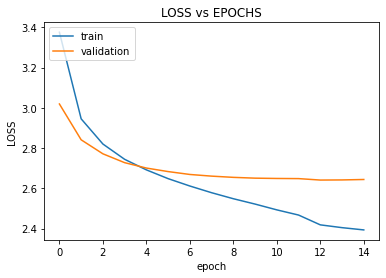

In [ ]:
#print history loss validation and training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title('LOSS vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

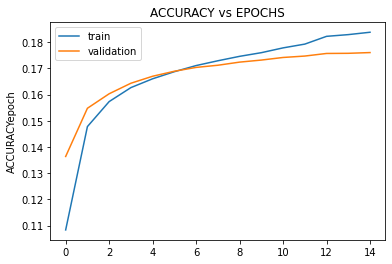

In [ ]:
#print history accuracy validation and training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('ACCURACYepoch')
plt.title('ACCURACY vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

**GREEDY SEARCH**

In [37]:
def predict_greedy(input_sentence):

    '''
    Predict the output based on the model it is trained on
    Args:
    input_sentence: the sentence for which you want the bot to answer

    Return:
    the predicted sentence
    '''
    enc_sent=encoder_token.texts_to_sequences(input_sentence)

    padded_enc_sent=pad_sequences(enc_sent,max_length_decoder,dtype='int32', padding='post')
    
  
    
    encoder_embed= model.layers[0].embedding_layer(padded_enc_sent)
    encoder_output, forward_h1,forward_c1,backward_h1,backward_c1=model.layers[0].lstm_layer1(encoder_embed)
    encoder_output, forward_h2,forward_c2,backward_h2,backward_c2=model.layers[0].lstm_layer2(encoder_output)

    enc_hidden_state1=Concatenate()([forward_h1,backward_h1])
    enc_cell_state1=Concatenate()([backward_h1,backward_c1])

    enc_hidden_state2=Concatenate()([forward_h2,backward_h2])
    enc_cell_state2=Concatenate()([backward_h2,backward_c2])
    states1=[enc_hidden_state1,enc_cell_state1]
    states2=[enc_hidden_state2,enc_cell_state2]

    word_count=0
    pred = []
    
    dec_input= np.ones((1, 1))
    #predicted_word=tknizer_eng.texts_to_sequences('<start>')
  # dec_input=tknizer_eng.texts_to_sequences('<start>')
    
    while (dec_input!=decoder_token.word_index['<end>']):
        
        output,states1,states2=model.layers[1].onestepDecoder(dec_input,states1,states2)
        dec_input=np.reshape(np.argmax(output), (1, 1))
        
        for key,value in decoder_token.word_index.items():
              if value==dec_input[0]:
                  word=key
        
        

        pred.append(word)
        word_count=word_count+1
    return pred


In [ ]:
max_length_encoder=max_length
max_length_decoder=max_length

In [ ]:
input_sentence=['hello',
                'how are you',
                'who is your master',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print('question-->',i)
    print('BOT-->',predict_greedy([i]))

question--> hello
BOT--> ['hello', '<end>']
question--> how are you
BOT--> ['i', 'am', 'not', '<end>']
question--> who is your master
BOT--> ['i', 'am', 'not', '<end>']
question--> are you sure you will be alright
BOT--> ['i', 'am', 'not', 'sure', '<end>']
question--> are you coming with me to London
BOT--> ['i', 'am', 'not', '<end>']
question--> do you know me
BOT--> ['i', 'am', 'not', '<end>']


In [ ]:
from  nltk.translate.bleu_score import sentence_bleu
val=validation.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
  
     candidate=predict_greedy([val['questions'].astype(str).iloc[i]])
     reference=[val['answers_out'].astype(str).iloc[i].split()]
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


The average BLEU score of these sentences is 0.41004935734124676


MODEL-2- Embedding weights Pretrained on GLOVE VECTORS


In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2021-10-08 16:45:21--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2021-10-08 16:45:21--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf632704d3dda62931a3bcbec47.dl.dropboxusercontent.com/cd/0/inline/BXqlLOKWYD_6hLt0-GVBF3O3n1N9y94fVqWxQJa6tM0B0Y-NLAxe5jKRETGMej66L4SQVjwh5Y1F216nr-_kE2y4wjJKLBo36WSI3287bdMRgy1WrnDXgkSaedqYN0XQlLOvcQe36lsPRYVTxbnEwYd5/file# [following]
--2021-10-08 16:45:21--  https://ucf632704d3dda62931a3bcbec47.dl.dropboxusercontent.com/cd/0/inline/BXqlLOKWYD_6hLt0-GVBF3O3n1N9y94fVqWxQJa6tM0B0Y-NLAxe5jKRETGMej66L4SQVjwh

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix_encoder = np.zeros((VOCAB_SIZE+1, 100))
for word, i in encoder_token.word_index.items():
   if i<5001:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix_encoder[i] = embedding_vector

embedding_matrix_decoder = np.zeros((VOCAB_SIZE+1, 100))

for word, i in decoder_token.word_index.items():
  if i<5001:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix_decoder[i] = embedding_vector

In [ ]:
embedding_size=100
enc_lstm_size1=256
enc_lstm_size2=256
dec_lstm_size1=512
dec_lstm_size2=512

enc_vocab_size=VOCAB_SIZE
dec_vocab_size=VOCAB_SIZE

model  = Encoder_Decoder_Model(enc_vocab_size,dec_vocab_size,embedding_size,enc_lstm_size1,enc_lstm_size2,dec_lstm_size1,dec_lstm_size2,max_length,embedding_weights_available=True)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.3868626806365509, patience=2, verbose=1,mode='min', min_delta=0.006267752196755831, cooldown=0, min_lr=0.0001)
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer,loss=custom_lossfunction,metrics=['acc'])
train_steps=train.shape[0]//batch_size
valid_steps=validation.shape[0]//batch_size
history2=model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[reduce_lr,early_stop])
model.summary()

using pretrained vector for embedding
Epoch 1/30
423/423 [==============================] - 219s 304ms/step - loss: 3.4874 - acc: 0.1011 - val_loss: 3.1988 - val_acc: 0.1189
Epoch 2/30
423/423 [==============================] - 101s 238ms/step - loss: 3.0193 - acc: 0.1416 - val_loss: 2.8635 - val_acc: 0.1528
Epoch 3/30
423/423 [==============================] - 101s 238ms/step - loss: 2.8397 - acc: 0.1567 - val_loss: 2.7801 - val_acc: 0.1596
Epoch 4/30
423/423 [==============================] - 101s 238ms/step - loss: 2.7604 - acc: 0.1616 - val_loss: 2.7381 - val_acc: 0.1629
Epoch 5/30
423/423 [==============================] - 101s 239ms/step - loss: 2.7057 - acc: 0.1655 - val_loss: 2.7053 - val_acc: 0.1663
Epoch 6/30
423/423 [==============================] - 108s 255ms/step - loss: 2.6636 - acc: 0.1680 - val_loss: 2.6835 - val_acc: 0.1685
Epoch 7/30
423/423 [==============================] - 101s 238ms/step - loss: 2.6235 - acc: 0.1704 - val_loss: 2.6676 - val_acc: 0.1705
Epoch 8/30

[]

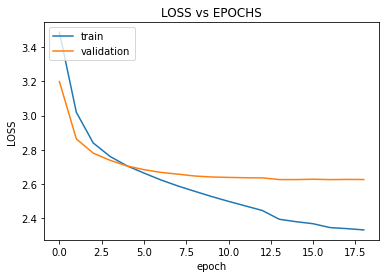

In [ ]:
#print history loss validation and training
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title('LOSS vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

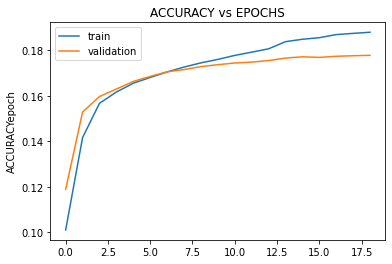

In [ ]:
#print history accuracy validation and training
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.ylabel('ACCURACYepoch')
plt.title('ACCURACY vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

In [ ]:
input_sentence=['hello',
                'how are you',
                'who is your master',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print('question-->',i)
    print('BOT-->',predict_greedy([i]))

question--> hello
BOT--> ['hello', '<end>']
question--> how are you
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', '<end>']
question--> who is your master
BOT--> ['i', 'am', 'not', 'sure', '<end>']
question--> are you sure you will be alright
BOT--> ['i', 'am', 'not', '<end>']
question--> are you coming with me to London
BOT--> ['i', 'am', 'not', '<end>']
question--> do you know me
BOT--> ['i', 'am', 'not', '<end>']


In [ ]:
from  nltk.translate.bleu_score import sentence_bleu
val=validation.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
  
     candidate=predict_greedy([val['questions'].astype(str).iloc[i]])
     reference=[val['answers_out'].astype(str).iloc[i].split()]
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


The average BLEU score of these sentences is 0.4040587137204993


MODEL3- Embedding weights Pretrained on Fasttext VECTORS


In [ ]:
!wget --header="Host: dl.fbaipublicfiles.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,mt;q=0.8,hi;q=0.7" --header="Referer: https://colab.research.google.com/" "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip" -c -O 'wiki-news-300d-1M.vec.zip'

--2021-10-08 17:56:24--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  10.7MB/s    in 64s     

2021-10-08 17:57:29 (10.2 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [ ]:
!unzip wiki-news-300d-1M.vec.zip 

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:

import io
fname='wiki-news-300d-1M.vec'
fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
n, d = map(int, fin.readline().split())

In [ ]:
lines=fin.readlines()
len(lines)

999994

In [ ]:
words_fasttext=[]
for i in lines[1:]:
    words_fasttext.append(i.split()[0])

In [ ]:
#EXTRACTION of Pretrained FASTTEXT vectors of 300 dimensions trained on Wikipedia


embedding_matrix_encoder = np.zeros((VOCAB_SIZE+1, 300))

for word, i in encoder_token.word_index.items():
  if i <5001:
      if word in words_fasttext:
        embedding_vector = lines[words_fasttext.index(word)+1].split()[1:]
        if embedding_vector is not None:
              embedding_matrix_encoder[i] = embedding_vector

embedding_matrix_decoder = np.zeros((dec_vocab_size+1, 300))
for word, i in decoder_token.word_index.items():
  if i<5001:
      if word in words_fasttext:
        embedding_vector = lines[words_fasttext.index(word)+1].split()[1:]
        if embedding_vector is not None:
              embedding_matrix_decoder[i] = embedding_vector

In [ ]:
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
embedding_size=300
enc_lstm_size1=256
enc_lstm_size2=256
dec_lstm_size1=512
dec_lstm_size2=512

enc_vocab_size=VOCAB_SIZE
dec_vocab_size=VOCAB_SIZE

model  = Encoder_Decoder_Model(enc_vocab_size,dec_vocab_size,embedding_size,enc_lstm_size1,enc_lstm_size2,dec_lstm_size1,dec_lstm_size2,max_length,embedding_weights_available=True)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.3868626806365509, patience=2, verbose=1,mode='min', min_delta=0.006267752196755831, cooldown=0, min_lr=0.0001)
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer,loss=custom_lossfunction,metrics=['acc'])
train_steps=train.shape[0]//batch_size
valid_steps=validation.shape[0]//batch_size
history3=model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[reduce_lr,early_stop])
model.summary()

using pretrained vector for embedding
Epoch 1/30
423/423 [==============================] - 433s 824ms/step - loss: 3.3648 - acc: 0.1118 - val_loss: 2.9852 - val_acc: 0.1422
Epoch 2/30
423/423 [==============================] - 100s 237ms/step - loss: 2.9148 - acc: 0.1506 - val_loss: 2.8172 - val_acc: 0.1566
Epoch 3/30
423/423 [==============================] - 100s 237ms/step - loss: 2.7919 - acc: 0.1598 - val_loss: 2.7473 - val_acc: 0.1621
Epoch 4/30
423/423 [==============================] - 100s 237ms/step - loss: 2.7233 - acc: 0.1645 - val_loss: 2.7081 - val_acc: 0.1660
Epoch 5/30
423/423 [==============================] - 100s 238ms/step - loss: 2.6700 - acc: 0.1683 - val_loss: 2.6823 - val_acc: 0.1686
Epoch 6/30
423/423 [==============================] - 100s 237ms/step - loss: 2.6282 - acc: 0.1708 - val_loss: 2.6634 - val_acc: 0.1707
Epoch 7/30
423/423 [==============================] - 100s 237ms/step - loss: 2.5915 - acc: 0.1730 - val_loss: 2.6510 - val_acc: 0.1720
Epoch 8/30

[]

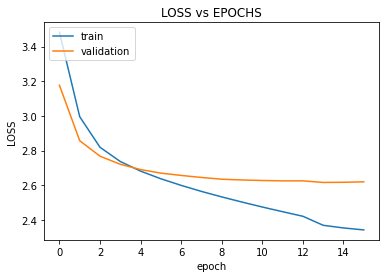

In [34]:
#print history loss validation and training
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title('LOSS vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

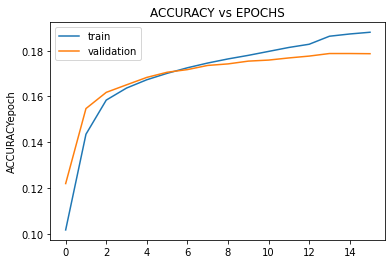

In [35]:
#print history accuracy validation and training
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.ylabel('ACCURACYepoch')
plt.title('ACCURACY vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

In [39]:
max_length_encoder=max_length
max_length_decoder=max_length

In [40]:
input_sentence=['hello',
                'how are you',
                'who is your master',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print('question-->',i)
    print('BOT-->',predict_greedy([i]))

question--> hello
BOT--> ['hello', '<end>']
question--> how are you
BOT--> ['i', 'am', 'not', '<end>']
question--> who is your master
BOT--> ['i', 'am', 'not', '<end>']
question--> are you sure you will be alright
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', '<end>']
question--> are you coming with me to London
BOT--> ['i', 'am', 'not', '<end>']
question--> do you know me
BOT--> ['i', 'am', 'not', '<end>']


In [41]:
from  nltk.translate.bleu_score import sentence_bleu
val=validation.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
  
     candidate=predict_greedy([val['questions'].astype(str).iloc[i]])
     reference=[val['answers_out'].astype(str).iloc[i].split()]
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


The average BLEU score of these sentences is 0.4616624808605121


<h2> OBSERVATION </h2>

 1.We can see all the three models are roughly performing the same with BLEU score for arbitrarily chosen 1000 validation questions with BLEU score in the range (0.40-0.46).

 2.Third model whic used pretrained Fasttext vectors in embedding layers performed slightly better than the other two.